In [1]:
import math
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from matplotlib.patches import Rectangle
import os
import re
from mpl_toolkits import mplot3d
from skimage.draw import polygon_perimeter
import pickle
import seaborn as sns

In [2]:
class Tracking:
    def __init__(self):
        self.trajectory={}
        self.mitosis={}
        self.time_series=0
        self.H=0
        self.W=0
        self.max_label=0
        self.num_img=30
        self.colors=sns.color_palette("hls", 100)
    def draw_trajectory(self):
        if self.time_series==0:
            return 
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        for key in self.trajectory.keys():
            xline=[]
            yline=[]
            start=None
            end=None
            started=None
            i=0
            for tup in self.trajectory[key]:
                if tup[1]!=-1:
                    started=True
                    x1, x2, y1, y2=tup[1], tup[2], tup[3], tup[4]
                    mid_x=(x2-x1)/2+x1
                    mid_y=(y2-y1)/2+y1
                    xline.append(mid_x)
                    yline.append(mid_y)
                else:
                    if start==None:
                        start=1
                    elif started==None:
                        start+=1
                    elif end==None:
                        end=i-1
                if i==self.time_series+1:
                    continue
                i+=1
                
                if start==None:
                    start=0
            if end==None:
                end=self.time_series-1
            zline = np.linspace(start=start, stop=end, num=end-start+1)
            if len(xline)!=len(zline):
                print("not same", len(xline), len(zline))
                continue
            ax.plot3D(xline, yline, zline)
        plt.show()
        
    def E_colour(self, cell_curr, cell_next):
#         I_next=np.mean(cell_next)
#         return math.sqrt(np.sum((cell_curr-I_next)**2)/(500*500))
        return
    
    def E_displacement(self, cell_curr_mid_x, cell_curr_mid_y, cell_next_mid_x, cell_next_mid_y):
        return math.sqrt((cell_next_mid_x-cell_curr_mid_x)**2+(cell_next_mid_y-cell_curr_mid_y)**2)/math.sqrt(self.H**2+self.W**2)
    
    def E_skewness(self, cell_prev_x, cell_prev_y, cell_curr_x, cell_curr_y, cell_next_x, cell_next_y):
        tux=cell_prev_x-cell_curr_x
        tuy=cell_prev_y-cell_curr_y

        uvx=cell_curr_x-cell_next_x
        uvy=cell_curr_y-cell_next_y

        bottom=math.sqrt((tux**2+tuy**2))*math.sqrt((uvx**2+uvy**2))
        return (1-(tux*uvx+tuy*uvy)/bottom)/2

    def E_area(self, curr_x1, curr_x2, curr_y1, curr_y2, next_x1, next_x2, next_y1, next_y2):
        Su=(curr_x2-curr_x1)*(curr_y2-curr_y1)
        Sv=(next_x2-next_x1)*(next_y2-next_y1)

        if curr_y1 < next_y2 and curr_y1 > next_y1:
            if curr_x2 > next_x1 and next_x2 > curr_x2:
                overlap=(next_y2-curr_y1)*(curr_x2-next_x1)
                return (1-(overlap**2)/(Su*Sv))
            elif curr_x1 < next_x2 and curr_x1 > next_x1:
                overlap=(next_y2-curr_y1)*(next_x2-curr_x1)
                return (1-(overlap**2)/(Su*Sv))
            else:
                return 1
        elif curr_y2 > next_y1 and curr_y2 < next_y2:
            if curr_x2 > next_x1 and next_x2 > curr_x2:
                overlap=(curr_y2-next_y1)*(curr_x2-next_x1)
                return (1-(overlap**2)/(Su*Sv))
            elif curr_x1 < next_x2 and curr_x1 > next_x1:
                overlap=(curr_y2-next_y1)*(next_x2-curr_x1)
                return (1-(overlap**2)/(Su*Sv))
            else:
                return 1
        elif curr_x1==next_x1 and curr_y1==next_y1:
            return 0
        else:
            return 1
    
    def E_deformation(self, curr_x1, curr_x2, curr_y1, curr_y2, next_x1, next_x2, next_y1, next_y2):
        Au=(curr_x2-curr_x1)*(curr_y2-curr_y1)
        Av=(next_x2-next_x1)*(next_y2-next_y1)
        Pu=2*(curr_x2-curr_x1)+2*(curr_y2-curr_y1)
        Pv=2*(next_x2-next_x1)+2*(next_y2-next_y1)
        Qu=(Pu**2)/(4*math.pi*Au**2)
        Qv=(Pv**2)/(4*math.pi*Av**2)
        return abs(Qu-Qv)/math.sqrt(Qu**2+Qv**2)
    
    def E_total(self, e_col, e_dis, e_def, e_area, e_skew):
        return 0.5*e_dis+0.25*e_area+0.25*e_skew
    
    
    def min_E(self, path, new_img, curr_cells, next_cells):
        selected=[]
        totals=[]
        e_info=[]
        new_next_cells=next_cells.copy()
        for n_cell_info in next_cells:
            n, n_cell, n_y1, n_y2, n_x1, n_x2=n_cell_info[0], n_cell_info[1], n_cell_info[2], n_cell_info[3], n_cell_info[4], n_cell_info[5]
            n_mid_x=(n_x2-n_x1)/2+n_x1
            n_mid_y=(n_y2-n_y1)/2+n_y1

            mini=100000
            new_label=-1
            index=-1
            
            for c_cell_info in curr_cells:
                c, c_cell, c_y1, c_y2, c_x1, c_x2=c_cell_info[0], c_cell_info[1], c_cell_info[2], c_cell_info[3], c_cell_info[4], c_cell_info[5]
                c_mid_x=(c_x2-c_x1)/2+c_x1
                c_mid_y=(c_y2-c_y1)/2+c_y1
                if c_mid_x > n_mid_x+20 or c_mid_x < n_mid_x-20:
                    continue
                if c_mid_y > n_mid_y+20 or c_mid_y < n_mid_y-20:
                    continue   
                 
                if self.time_series==0:
                    e_skew=0
                else:
                    prev=self.trajectory[c][self.time_series-1]
                    prev_x1, prev_x2, prev_y1, prev_y2=prev[1], prev[2], prev[3], prev[4]
                    prev_mid_x=(prev_x2-prev_x1)/2+prev_x1
                    prev_mid_y=(prev_y2-prev_y1)/2+prev_y1
                    e_skew=self.E_skewness(prev_mid_x, prev_mid_y, c_mid_x, c_mid_y, n_mid_x, n_mid_y)
                e_colour=self.E_colour(n_cell, c_cell)
                e_dis=self.E_displacement(c_mid_x, c_mid_y, n_mid_x, n_mid_y)
                e_def=self.E_deformation(c_x1, c_x2, c_y1, c_y2, n_x1, n_x2, n_y1, n_y2)
                e_area=self.E_area(c_x1, c_x2, c_y1, c_y2, n_x1, n_x2, n_y1, n_y2)
                e_total=self.E_total(e_colour, e_dis, e_def, e_area, e_skew)
                e_info.append((n, c, e_total))

        e_info = sorted(e_info, key=lambda tup: tup[2])
        selected_n=[]
        selected_c=[]
        for info in e_info:
            n=info[0]
            if n in selected_n:
                continue
            c=info[1]
            if c in selected_c:
                continue
            temp=list(new_next_cells[n])
            temp[0]=c
            new_next_cells[n]=tuple(temp)

            y1, y2, x1, x2=new_next_cells[n][2], new_next_cells[n][3], new_next_cells[n][4], new_next_cells[n][5]
            if c not in self.trajectory.keys():
                self.trajectory[c]=[(-1, -1, -1, -1, -1)]*self.time_series
            self.trajectory[c].append((new_next_cells[n][1], x1, x2, y1, y2))

            selected_n.append(n)
            selected_c.append(c)
        for n in range(len(next_cells)):
            if n not in selected_n:
                print(n)
                self.max_label+=1
                temp=list(new_next_cells[n])
                temp[0]=self.max_label
                new_next_cells[n]=tuple(temp)
                y1, y2, x1, x2=new_next_cells[n][2], new_next_cells[n][3], new_next_cells[n][4], new_next_cells[n][5]

                if self.max_label not in self.trajectory.keys():
                    self.trajectory[self.max_label]=[(-1, -1, -1, -1, -1)]*self.time_series
                self.trajectory[self.max_label].append((new_next_cells[n][1],x1, x2, y1, y2))
        self.draw_bounding_box(new_img, new_next_cells)
        return new_next_cells

    def draw_bounding_box(self, new_img, new_next_cells):
        plt.figure()
        for i in range(len(new_next_cells)):
            label, cells, y1, y2, x1, x2=new_next_cells[i]
            plt.title("Number of Cells: "+str(len(new_next_cells))+"Max: "+str(self.max_label))
            plt.imshow(new_img, interpolation="nearest")
            rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
            plt.axes().add_patch(rect) 
            plt.text(x1+1,y1+1, str(label))
            x_centroid=[]
            y_centroid=[]
            for t in self.trajectory[i]:
                if t[1]==-1:
                    continue
                x_centroid.append(((t[2]-t[1])/2+t[1]))
                y_centroid.append(((t[4]-t[3])/2+t[3]))
            col=self.colors[i]
#             plt.plot(x_centroid, y_centroid, col)
            plt.plot(x_centroid, y_centroid)
        plt.show()  
        self.time_series+=1
        return
    
    def draw_mitosis(self, img_path):
        path=img_path.split("/")
        path="/".join(path[1:])
        image_names=sorted(os.listdir(img_path))
        i=0
    
        for name in image_names:
            print(i)
            if name.endswith(".npy"):
                continue
                
            if not os.path.isdir("mitosis/"+path):
                os.makedirs("mitosis/"+path)
            
            if i not in self.mitosis:
                img=cv2.imread(img_path + name, 0)
                dim = (500, 500)
                img = cv2.resize(img, dim)
                
                plt.figure()
                plt.imshow(img, interpolation="nearest")
                for key in self.trajectory:
                    x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                    if(x1==-1):
                        continue
                    rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
                    plt.axes().add_patch(rect)
                    plt.text(x1+1,y1+1, str(key))
                    
                    x_centroid=[]
                    y_centroid=[]
                    count=0
                    for t in self.trajectory[key]:
                        if t[1]==-1:
                            continue
                        if count > i:
                            continue
                        x_centroid.append(((t[2]-t[1])/2+t[1]))
                        y_centroid.append(((t[4]-t[3])/2+t[3]))
                        count+=1
                    col=self.colors[key]
                    plt.plot(x_centroid, y_centroid, color=col)
                    
                plt.gca().set_axis_off()
                plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
                plt.margins(0,0)
                plt.savefig("mitosis/"+path+name,bbox_inches='tight', pad_inches=0.0)
                plt.show()
                if i==self.num_img:
                    break
                i+=1
                
                continue
            plt.figure()
            img=cv2.imread(img_path + name, 0)
            dim = (500, 500)
            img = cv2.resize(img, dim)
            for key in self.trajectory:
                plt.imshow(img, interpolation="nearest")
                x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                if x1==-1:
                    continue
                rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
                plt.axes().add_patch(rect)
                plt.text(x1+1,y1+1, str(key))
                x_centroid=[]
                y_centroid=[]
                count=0
                for t in self.trajectory[key]:
                    if t[1]==-1:
                        continue
                    if count > i:
                        continue
                    x_centroid.append(((t[2]-t[1])/2+t[1]))
                    y_centroid.append(((t[4]-t[3])/2+t[3]))
                    count+=1
                col=self.colors[key]
                plt.plot(x_centroid, y_centroid, color=col)
                
            for key in self.mitosis[i]:
                x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                if x1==-1:
                    continue
                rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='yellow')
                plt.axes().add_patch(rect)
                plt.text(x1+1,y1+1, str(key))
                x_centroid=[]
                y_centroid=[]
                count=0
                for t in self.trajectory[key]:
                    if t[1]==-1:
                        continue
                        
                    if count > i:
                        continue
                    x_centroid.append(((t[2]-t[1])/2+t[1]))
                    y_centroid.append(((t[4]-t[3])/2+t[3]))
                    count+=1
                col=self.colors[key]
                plt.plot(x_centroid, y_centroid, color=col)
                
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.savefig("mitosis/"+path+name,bbox_inches='tight', pad_inches=0.0)
            plt.show()
            if i==self.num_img:
                break
            i+=1
    
    def recover_trajectory(self):
        for t in self.trajectory:
            diff=self.time_series-len(self.trajectory[t])
            temp=[(-1, -1, -1, -1, -1)]*diff
            self.trajectory[t].extend(temp)
        how_many=0
        def find_BC(k, n, mid_x, mid_y):
            next_=n+1
            next_next=n+2
            B=[]
            C=[]
            b_key=[]
            c_key=[]
            for key in self.trajectory.keys():
                if key==k:
                    continue          
                if  self.trajectory[key][n][1]!=-1 and self.trajectory[key][next_][1]!=-1:
                    x1, x2, y1, y2=self.trajectory[key][n][1], self.trajectory[key][n][2], self.trajectory[key][n][3], self.trajectory[key][n][4]
                    next_mid_x=(x2-x1)/2+x1
                    next_mid_y=(y2-y1)/2+y1
                    if next_mid_x < mid_x-10 or next_mid_x > mid_x+10:
                        continue
                    if next_mid_y < mid_y-10 or next_mid_y > mid_y+10:
                        continue
                    if self.trajectory[key][next_next][1]!=-1:
                        B.append(self.trajectory[key])
                        b_key.append(key)
                    else:
                        C.append(self.trajectory[key])
                        c_key.append(key)
            return (B, C, b_key, c_key)
            
            
        for key in self.trajectory.keys():
            arr = self.trajectory[key]
            exists=0
            n=len(arr)-1
            candidateB=[]
            candidateC=[]
            comp_info_b=[]
            comp_info_c=[]
            while n>=0:
                if arr[n][1]!=-1: 
                    if exists==0:
                        exists=1
                elif exists==1 and arr[n][1]==-1:
                    x1, x2, y1, y2=arr[n+1][1], arr[n+1][2], arr[n+1][3], arr[n+1][4]
                    mid_x=(x2-x1)/2+x1
                    mid_y=(y2-y1)/2+y1
                    if n+2 > len(arr)-1:
                        n-=1
                        continue
                    (candidateB, candidateC, b_key, c_key)=find_BC(key, n, mid_x, mid_y)

                    exists=0
                    break
                n-=1
            if exists==1:
                continue

            a_x1, a_x2, a_y1, a_y2=arr[n+1][1], arr[n+1][2], arr[n+1][3], arr[n+1][4]
            a_mid_x=(a_x2-a_x1)/2+a_x1
            a_mid_y=(a_y2-a_y1)/2+a_y1
            if len(candidateC)!=0:
                for c_C in candidateC: 
                    c_x1, c_x2, c_y1, c_y2=c_C[n][1], c_C[n][2], c_C[n][3], c_C[n][4]
                    c_mid_x=(c_x2-c_x1)/2+c_x1
                    c_mid_y=(c_y2-c_y1)/2+c_y1
                    e_dis=self.E_displacement(a_mid_x, a_mid_y, c_mid_x, c_mid_y)
                    comp_info_c.append(e_dis)
                best_c_C = candidateC[comp_info_c.index(min(comp_info_c))]
            if len(candidateB)!=0:
                for b_B in candidateB: 
                    b_x1, b_x2, b_y1, b_y2=b_B[n][1], b_B[n][2], b_B[n][3], b_B[n][4]
                    b_mid_x=(b_x2-b_x1)/2+b_x1
                    b_mid_y=(b_y2-b_y1)/2+b_y1
                    e_dis=self.E_displacement(a_mid_x, a_mid_y, b_mid_x, b_mid_y)
                    comp_info_b.append(e_dis)
                best_b_B = candidateB[comp_info_b.index(min(comp_info_b))]

            if len(candidateC)==0 and len(candidateB)==0:
                continue
            
            elif len(candidateC)==0:
                if n not in self.mitosis:
                    self.mitosis[n]=[]
                self.mitosis[n].append(b_key[comp_info_b.index(min(comp_info_b))])
                continue
                
            elif len(candidateB)==0:
                key_update = c_key[comp_info_c.index(min(comp_info_c))]
                how_many+=1
                for i in (n+1,self.time_series-1):
                    self.trajectory[key_update][i] = arr[i]
                continue
                
            if min(comp_info_b) > min(comp_info_c) :
                key_update = c_key[comp_info_c.index(min(comp_info_c))]
                how_many+=1
                for i in (n+1,self.time_series-1):
                    self.trajectory[key_update][i] = arr[i]
            else:
                if n not in self.mitosis:
                    self.mitosis[n]=[]
                self.mitosis[n].append(b_key[comp_info_b.index(min(comp_info_b))])
        return self.mitosis
    
    def tracking(self, image_path, info_path):
        image_names=sorted(os.listdir(image_path))
        curr_cells=None
        i=0
        for path in image_names:
            if path.endswith(".npy"):
                continue
            img=cv2.imread(image_path + path, 0)
            dim = (500, 500)
            img = cv2.resize(img, dim)
            self.H, self.W=img.shape
            info=np.load(info_path+path.split('.')[0]+'.npy', allow_pickle=True)
            print(path.split('.')[0]+'.npy', path)
            if isinstance(curr_cells, type(None)):
                curr_cells=info
                for cell in curr_cells:
                    label, cropped, y1, y2, x1, x2 = cell[0], cell[1], cell[2], cell[3], cell[4], cell[5]
                    self.trajectory[label]=[]
                    self.trajectory[label].append((cropped, x1, x2, y1, y2))
                    self.max_label=label
                self.draw_bounding_box(img, curr_cells)
                continue
            next_cells=info
            curr_cells=self.min_E(path, img, curr_cells, next_cells)
            if i==self.num_img:
                break
            i+=1

t000.npy t000.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

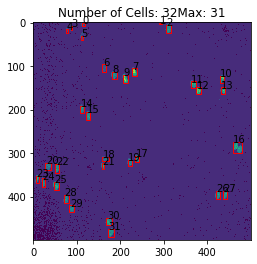

t001.npy t001.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

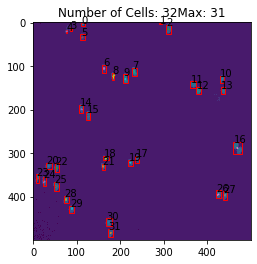

t002.npy t002.tif
11


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

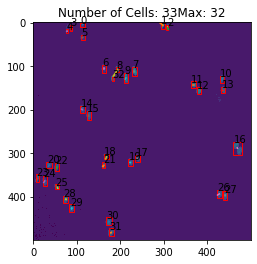

t003.npy t003.tif
15
19
33


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

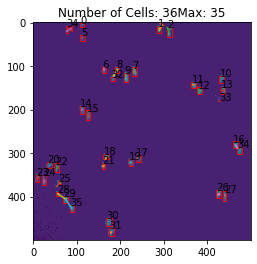

t004.npy t004.tif
5
6
11
36


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

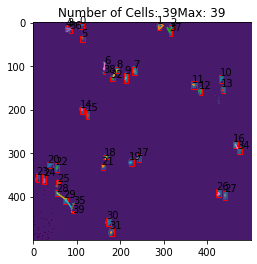

t005.npy t005.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

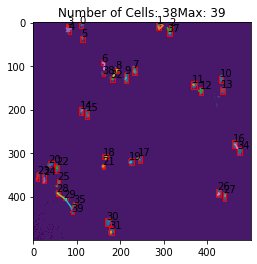

t006.npy t006.tif
17
18
36


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

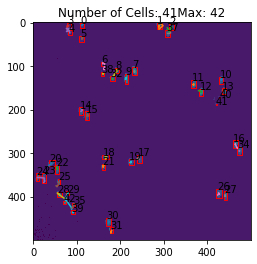

t007.npy t007.tif
39


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

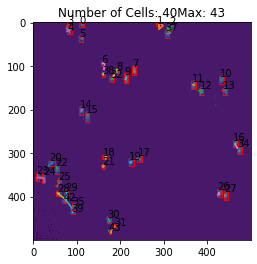

t008.npy t008.tif
40


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

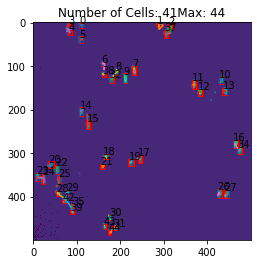

t009.npy t009.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

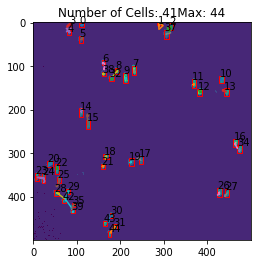

t010.npy t010.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

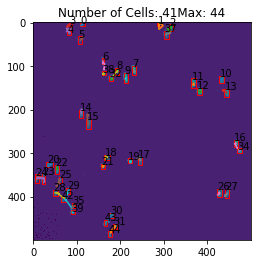

t011.npy t011.tif
21
22
29


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

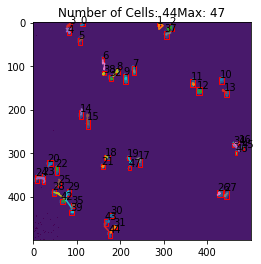

t012.npy t012.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

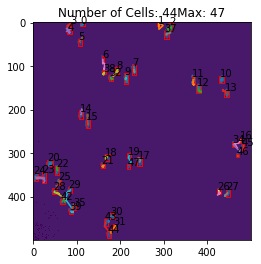

t013.npy t013.tif
16
38


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

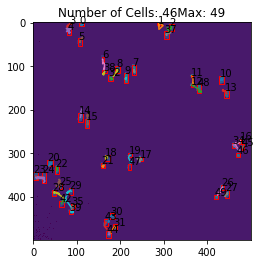

t014.npy t014.tif
29
40


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

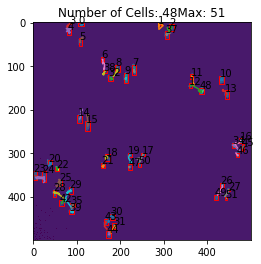

t015.npy t015.tif
17
29
33


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

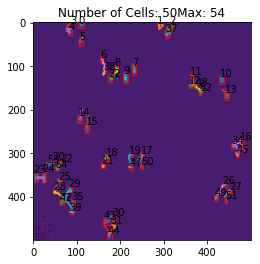

t016.npy t016.tif
23


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

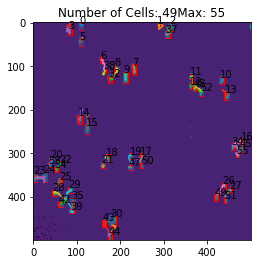

t017.npy t017.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

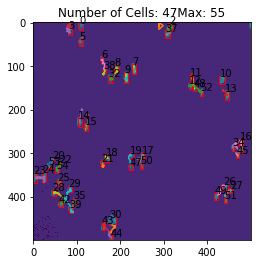

t018.npy t018.tif
1
21


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

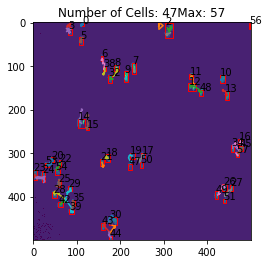

t019.npy t019.tif
13
17
45


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

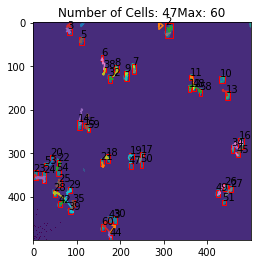

t020.npy t020.tif
0
1


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

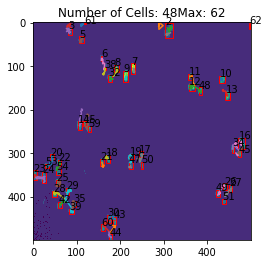

t021.npy t021.tif
1
16


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

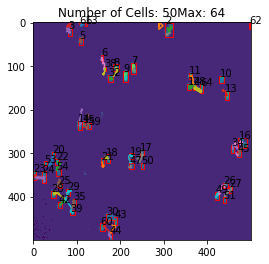

t022.npy t022.tif
19
24
36


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

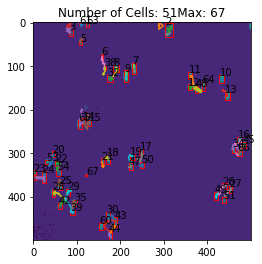

t023.npy t023.tif
5


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

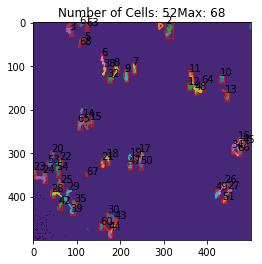

t024.npy t024.tif
1


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

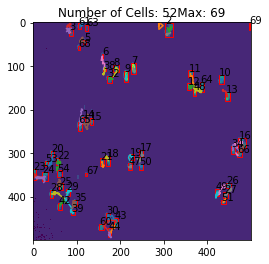

t025.npy t025.tif
38


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

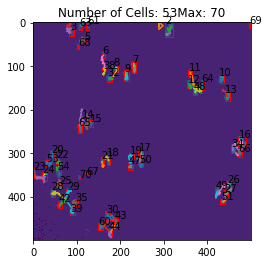

t026.npy t026.tif
39


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

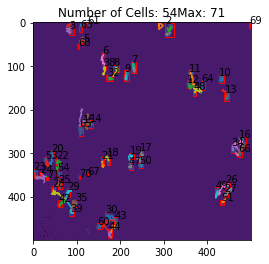

t027.npy t027.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

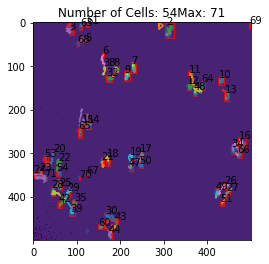

t028.npy t028.tif
53


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

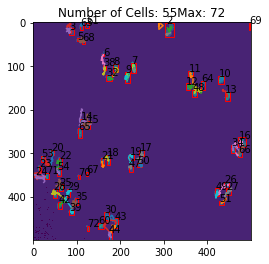

t029.npy t029.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

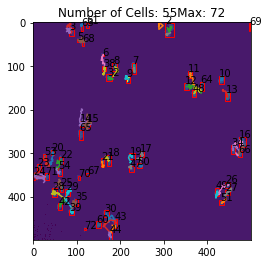

t030.npy t030.tif
43
53


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

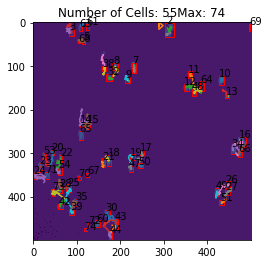

t031.npy t031.tif
7
15
20


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizu

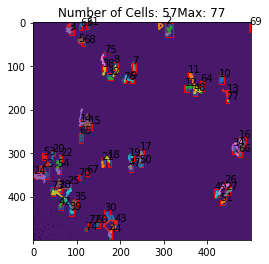

0
0


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

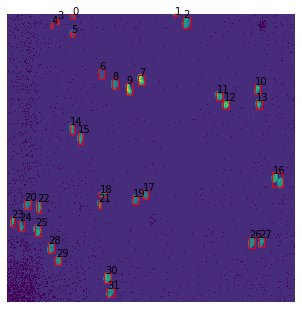

1
1


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

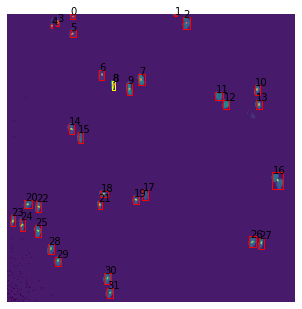

2
2


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

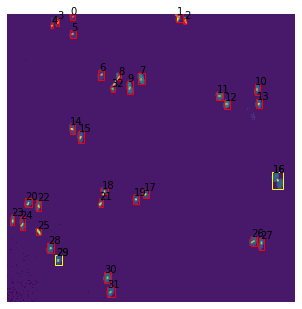

3
3


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

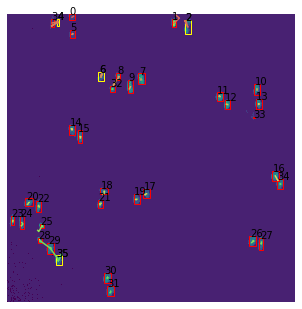

4
4


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

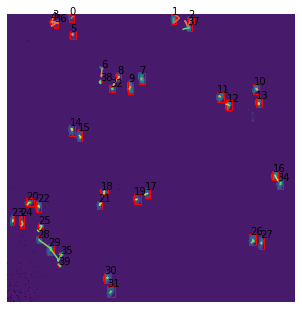

5
5


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

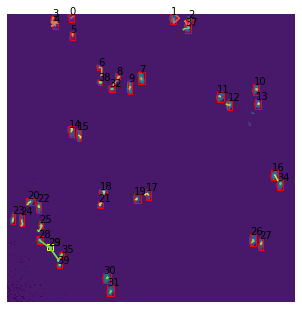

6
6


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

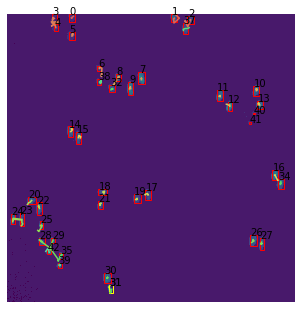

7
7


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

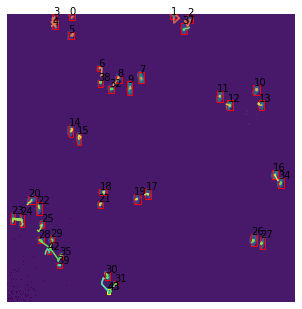

8
8


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

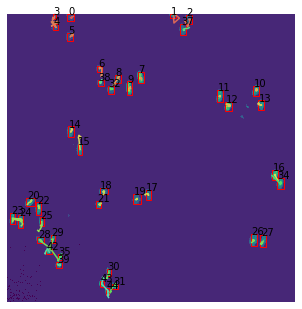

9
9


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

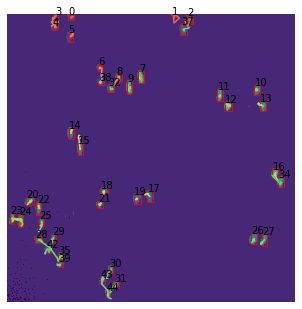

10
10


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

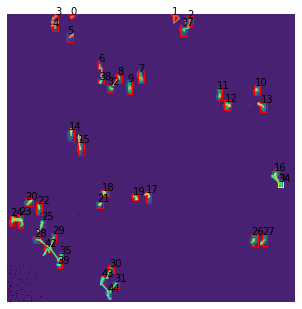

11
11


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

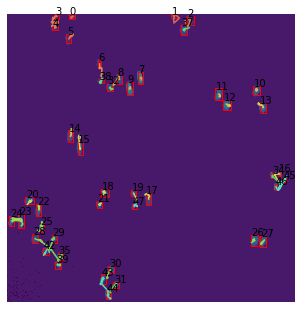

12
12


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

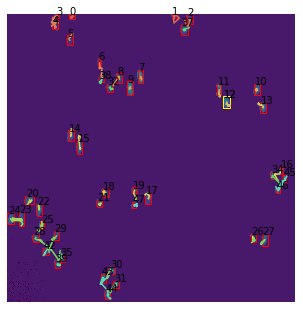

13
13


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

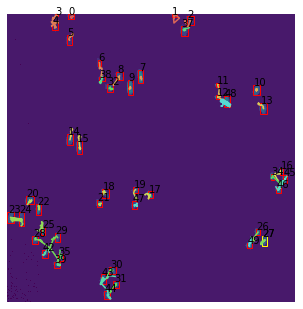

14
14


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

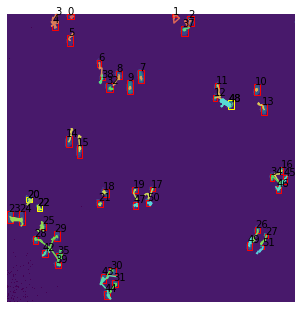

15
15


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

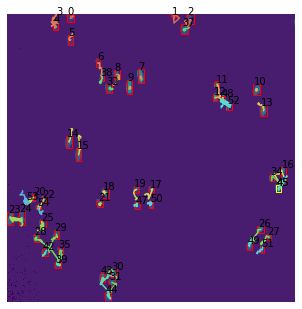

16
16


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

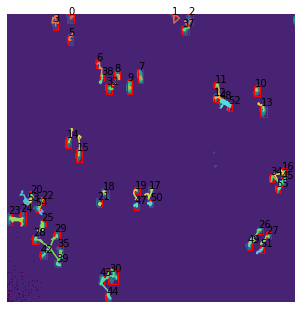

17
17


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

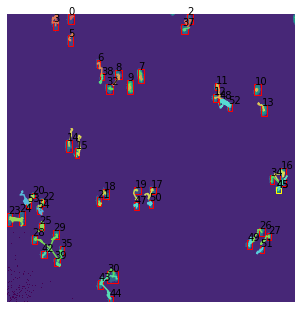

18
18


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

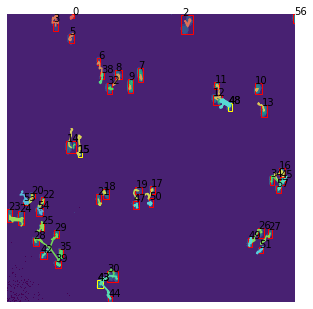

19
19


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

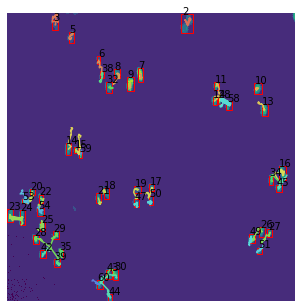

20
20


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

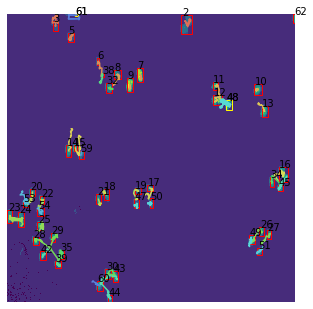

21
21


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

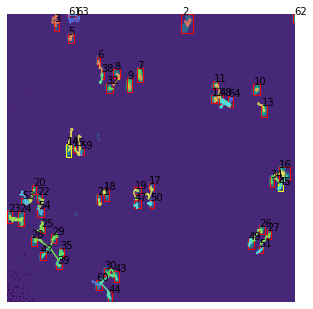

22
22


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

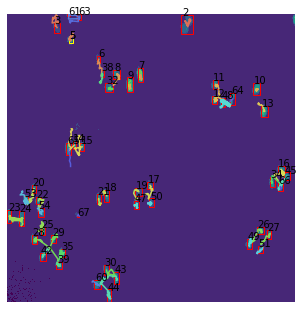

23
23


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

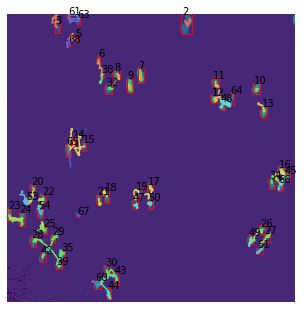

24
24


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

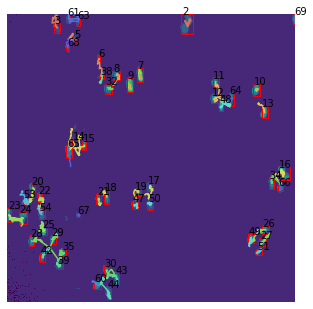

25
25


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

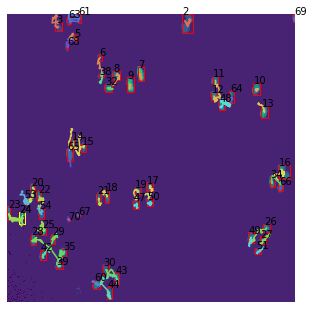

26
26


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

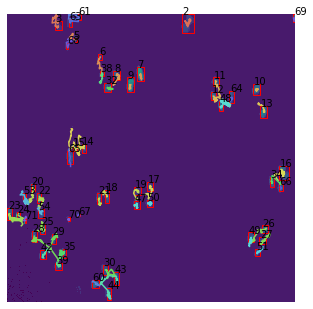

27
27


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

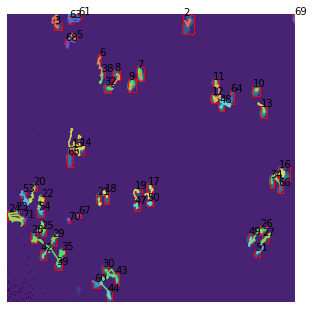

28
28


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

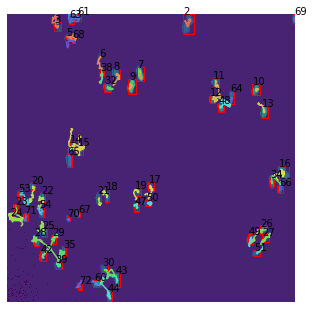

29
29


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

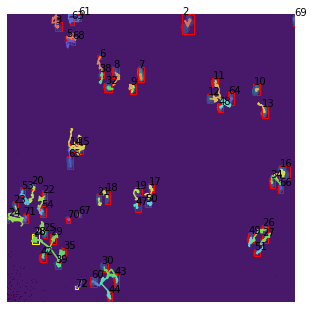

30
30


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

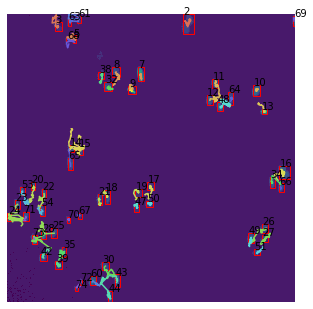

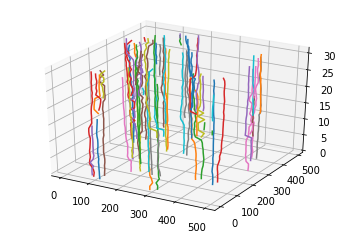

In [3]:
# files=['./dic/Sequence 1/','./fluo/Sequence 1/','./phc/Sequence 1/']
files=['./fluo/Sequence 1/']
for file in files:
    path=file.split("/")
    path="/".join(path[1:])
    task1=Tracking()
    task1.tracking(file, file)
    mitosis=task1.recover_trajectory()
    task1.draw_mitosis(file)
    task1.draw_trajectory()
    if not os.path.isdir("mitosis/"+path):
        os.makedirs("mitosis/"+path)
        
    with open('mitosis/'+path+'trajectory.pkl', 'wb') as f:
        pickle.dump(task1.trajectory, f, pickle.HIGHEST_PROTOCOL)
        
    with open('mitosis/'+path+'mitosis.pkl', 'wb') as f:
        pickle.dump(mitosis, f, pickle.HIGHEST_PROTOCOL)
        
    